# PARTIE 1 --- GOOGLE PLAY STORE APPS

In [1]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from math import sqrt
from sklearn import mixture
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn import linear_model
import statsmodels.api as sm
from pylab import *
import numpy as np
from IPython.display import display, HTML
from scipy import stats
from scipy.spatial import distance
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import math
from sklearn.naive_bayes import MultinomialNB

Cette classe permet à partir d'un fichier CSV de faire un traitemement afin de pouvoir utiliser ces données par la suite. Nous avons essayé au maximum de la faire la plus géneraliste possible afin de pouvoir la réutiliser dans des projets futurs.<br><br>
Pour pouvoir utiliser cette classe, il nous faut fournir au constructeur comme arguments : <br>
<b>trainData:</b><i>fichier CSV de départ</i><br>
<b>separateur:</b><i>séparateur utilisé dans le fichier utilisé</i><br> 
<b>columnExp:</b><i>Dans le cas de la régression colonne de la variable à expliquer, dans le cas de clustering supervisé la colonne qui correspond à la classe d'appartennance, et dans le cas de clustering non supervisé laisser vide (chaîne vide).</i><br>
<b>columnIgnore:</b><i>colonne à ignorer de notre fichier CSV(DataSet)</i><br>
<b>columnQuanta:</b><i>Ensemble des colonnes quantitatives de notre fichier CSV</i><br>
<b>columnQualita:</b><i>Ensemble des colonnes qualitatives de notre fichier (categorical variable)</i><br>
<h3>Méthodes</h3>
<li><b>traiterColumnQuanta:</b> Méthode qui permet un traitement de toutes les colonnes quantitatives , vérifient la non présence de caractere alphabétique , si c'est le cas dans le cas où la chaine est composée uniquement de deux caracteres, on vérifie si ces caracteres correspondent aux caracteres souvent utilisés pour exprimmer kilo, mega etc. (k,M) , si la chaine est composée de plus de deux caracteres alors la valeur de cette chaine sera potentiellement considérée comme une modalité d'une variable qualitative selon le degré de recurrence défini, afin de pouvoir caster en float par la suite </li>
<li><b>traiterColumnQualita:</b> Permet de représenter chaque modalite des colonnes catégorielles avec un codage binaire 1 dans le cas ou l'individu est présent dans cette catégorie 0 sinon</li>
<li><b>getVarExplication:</b> Méthode qui retourne les colonnes quantitatives(Méthode créer pour un confort de "code" ou pourrait bien acceder a ces attributs directement a partir de l'instance d'objet)</li>
<li><b>getTabReady:</b> Méthode qui retourne le dataframe avec toutes les variables catégorielles recodées à l'aide du codage binaire ainsi qu'un tri effectué sur les données quantitatives afin de supprimer les individu extremes avec une valeur sur une colonne supérieure ou inferieure à 4 fois l'ecart type</li>
<h4>Arguments des méthodes</h4>
<table>
    <thead>
        <tr>
            <th>Arguments</th>
            <th>METHODES : traiterColumnQuanta</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>quantaToQualita</td>
            <td>Variable booléenne qui permet d'activer l'option qui transforme les chaines de caracteres qui se répètent selon une certaine récurrence en variables qualitatives</td>
        </tr>
        <tr>
            <td>recurence</td>
            <td>Le nombre de récurrence à atteindre afin de considérer la chaine comme variable qualitative</td>
        </tr>
    </tbody>
</table>
<table>
    <thead>
        <tr>
            <th>Arguments</th>
            <th>METHODES: traiterColumnQualita</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>numberModalite</td>
            <td>Nombre minimun d'individus à atteindre pour une modalité afin de considérer la modalité comme pertinente, par exemple si il y a uniquement un seul individu qui appartienr a cette modalité il est inutile de la converver </td>
        </tr>
    </tbody>
</table>
<table>
    <thead>
        <tr>
            <th>Arguments</th>
            <th>METHODES: getTabReady</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>columnQuanta</td>
            <td>Variable booléen qui permet d'activer l'option qui transforme les chaines de caracteres qui se répètent selon une certaine récurrence en varaibles qualitatives</td>
        </tr>
        <tr>
            <td>recurence</td>
            <td>Le nombre de récurrence à atteindre afin de considérer la chaine comme variable qualitative</td>
        </tr>
        <tr>
            <td>recurrenceQualita</td>
            <td>Nombre minimun d'individus à atteindre pour une modalité afin de considérer la modalité comme pertinente, par exemple si il y a uniquement un seul individu qui appartient a cette modalité il est inutile de la converver </td>
        </tr>
    </tbody>
</table>



In [2]:
class csvToTab :
    def __init__(self,trainData,separateur,columnExp,columnIgnore,columQuanta,columnQualita):
        df = pd.read_csv(trainData,separateur)#Lecture du fichier CSV
        df = df.drop(columns=columnIgnore)#Supression dans notre jeu donnée des colonnes à ignorer 
        self.data = df #Attribution du jeu de donnée à notre objet
        if(not (columnExp=="")):#Dans le cas de certains algorithme nous avons pas de colonne à expliquer certains algorithme de cluster par exemple 
            self.data[columnExp] =  self.data[columnExp].fillna(0)#Pour le fichier application google on remplace les NAN par 0
        self.colonne = df.axes[1] #Colonne de notre dataset
        self.columnExp = columnExp #Colonne à expliquer de notre dataset
        self.columnIgnore=columnIgnore#Colonne à ignorer de notre dataset
        self.columnQuanta=columQuanta#Colonne quantitatives de notre jeu de données
        self.columnQualita=columnQualita#Colonne qualitatives de notre jeu de données
        if (not (columnExp == "")):#Si il y'a une colonne à expliquer
            self.seriesExp = df[[columnExp]]
    def traiterColumnQuanta(self,quantaToQualita,recurence): #Méthode qui permet d'effectuer un traitement sur les colonnes quantitatives
        qualitaToAdd = {} #Dictionnaire de valeur qui sont dans des colonnes quantitatives mais qu'on va potentiellement considérée comme qualitatives
        all_dummies = {} #Dictionnaire des dummies renvoyée par la fonction get_dummies de pandas 
        for col in self.colonne: #Pour chaque colonne de notre dataset
            if(col in self.columnQuanta): #Si la colonne est une colonne quantitatives
                i=0
                char = False
                for string in self.data[col] : #Pour chaque valeur de cette colonne
                    if(re.search('[a-z]{2}|[A-Z]{2}',str(string)) and not re.search('and',str(string)) and quantaToQualita): #Si la valeur contient une suite de 2 caractere minuscule ou majscule est qu'on as activer l'option qui permet de transformer certaines valeur en qualitatives varies with device par exemple dans size
                        if((str(string),col) not in qualitaToAdd): #Si la valeur n'a jamais était ajouter 
                            qualitaToAdd[str(string),col] = 1
                            all_dummies[col] = pd.get_dummies(self.data[col])#On récupere par un codage binaire toutes les valeur qui corresponde a cette colonne on effectuera un tri par la suite
                        else:
                            qualitaToAdd[str(string),col] = qualitaToAdd.get((str(string),col)) +1 #Permet d'obtenir le nombre de fois ou cette valeur à etait rencontrer
                        char=True #Etant donnée qu'on as deux caractères à la suite on considere cette valeur comme étant une chaine de caractere
                    if(re.search('[a-z]{2}|[A-Z]{2}',str(string)) and not re.search('and',str(string))):
                        char=True
                    if(not char):
                        coeffMulti = 1
                        if(re.search('[0-9]M',str(string))): #Si la valeur contient un coefficient multiplicateur écrit sous forme M,k
                            coeffMulti = 1000000
                        if(re.search('[0-9]k',str(string))):
                            coeffMulti = 1000
                        if(re.search('[0-9]|\.',str(string)) and isinstance(self.data.at[i,col],str)): #Si l'instance est considérée comme un string par numpy on remplace les , en .
                            self.data.at[i,col] = ''.join((re.findall('[0-9]|\.',str(string))))
                            self.data.at[i,col] = self.data.at[i,col].replace('.',',',1)
                            self.data.at[i,col] = self.data.at[i,col].replace('.','')
                            self.data.at[i,col] = self.data.at[i,col].replace(',','.')
                            self.data.at[i,col] = str(float(self.data.at[i,col])*coeffMulti)
                            
                    i=i+1
                    char=False
        quantaToQualita = pd.DataFrame()
        for a in qualitaToAdd.items() : #pour chaque valeur à potentiellement considérer comme valeur qualitatives
            if (a[1] > recurence): #Si le nombre de fois ou on as rencontrer cette valeur est supérieur a ce qu'on a définit comme critère
                col = all_dummies.get(a[0][1])[a[0][0]] #On récupére la colonne qui correspond à cette valeur dans le dictionnaire all_dummies
                name = a[0][1]+ "_"+a[0][0] #On récupere le nom de la valeur 
                active = pd.DataFrame([col],index=[name]) #On constitue un dataframe à partir de notre série 
                active = active.transpose() #On transpose , en effet lors de la création du dataframe il a agencer les valeur en ligne et non pas en colonne
                quantaToQualita = quantaToQualita.combine_first(active) #On ajoute au dataframe la nouvelle colonne
        return quantaToQualita
    def traiterColumnQualita(self,numberModalite):
        qualita = pd.DataFrame()
        for col in self.colonne: #Pour chaque colonne de notre dataframe 
            if(col in self.columnQualita): #Si la colonne est une colonne qualitatives
                a=pd.get_dummies(self.data[col]) #On récupere le codage binaire de cette colonne 1 pour appartenance et 0 le cas contraire
                colonne = a.axes[1] #On récupere le nom de toutes les modalité de la colonne
                number = a.sum(axis=0) #On récupére le nombre d'individu possédant cette modalité
                i=0
                for col2 in colonne:
                    if(number[i]>numberModalite): #Si le nombre d'individu qui possede cette modalité est supérieur aux nombre de modalité défini on ajoute cette modalité 
                        qualita = qualita.combine_first(a[[col2]])
                    i=i+1
        return qualita
    def getVarExplication(self):
        return self.data[self.columnQuanta] #Retourne les valeurs des colonnes quantitatives , methode pour le confort de code on a directement accès a ces valeur depuis l'objet
    def getTabReady(self,columnQuanta,recurrence,recurrenceQualita): #Méthode qui appel toutes les méthodes precedentes et effectue un tri sur les valeur extreme
        tab = self.traiterColumnQuanta(columnQuanta,recurrence)
        tab2 = self.traiterColumnQualita(recurrenceQualita)
        
        if (not (self.columnExp == "")):
                tabData = self.seriesExp
        tabExp = self.getVarExplication()
        tabFinal =tabExp.combine_first(tab2)
        tabFinal = tabFinal.combine_first(tab)
        col = self.columnQuanta
        if(not (self.columnExp == "")):
            tabFinal = tabFinal.combine_first(tabData)
        for coll in col:
            tabFinal[coll] = pd.to_numeric(tabFinal[coll],errors='coerce')
            tabFinal = tabFinal[(tabFinal[coll] >= tabFinal[coll].mean() - 4*sqrt(tabFinal[coll].var())) & (tabFinal[coll] <= tabFinal[coll].mean() + 4*sqrt(tabFinal[coll].var())) ] #Elimination des valeur extreme
        return tabFinal

<strong>On importe notre fichier et on lui applique un tri à l'aide de la classe créer précedemment et on va recupérer le dataframe dans la variable tabFinal. On supprime les lignes où une valeur NULL apparaît. (Dans les champs rating on a remplacé les null par des 0 car dans ce cas cela a du sens, les applications non notées sont du au fait d'un manque de succès donc on peut leur assigner une note de 0.) Lors de la définition de la classe nous avons communiqué a la classe le fait de considerer Android Ver et current ver comme des variables quantitatives car une version peut etre vu comme une variable continue même si elle prend des valeurs discrete. Et plus la version est haute plus le mobile est récent</strong> 

In [3]:
fichier = csvToTab("googleplaystore.csv",",","Rating",["App"],["Android Ver","Current Ver","Reviews","Size","Price","Installs"],["Category","Content Rating","Genres","Type","Last Updated"]) #On instancie notre objet en definissant la colonne a explique etc ...
tabFinal = fichier.getTabReady(False,200,60) #On crée notre tableau avec la désactivation de l'option quantaToQualita,200 qui ne sert à rien etant donnée que l'option est désactiver , et un nombre minimun de 60 personne qui appartiennent à une modalité pour la conserver
tabFinal = tabFinal.dropna() #On supprime les lignes qui contiennent une valeur nulle


Variance PRIX : 4.579727646950558
Variance Android Ver : 0.6920517711381186


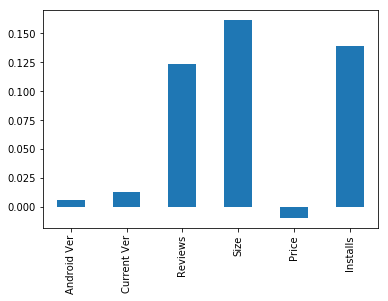

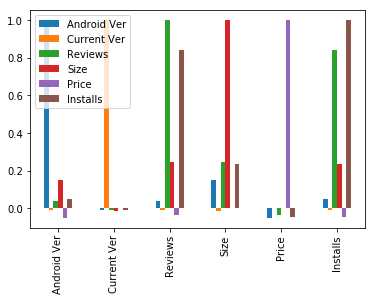

In [4]:
quanta = tabFinal.filter(items=fichier.columnQuanta) #On séléctionne uniquement les colonnes quantitatives
quantaWithRating= quanta.corrwith(tabFinal['Rating']) #On obtient la corrélation avec le champ rating
qunataWithQuanta=quanta.corr() #Corrélation entre les varaibles quantitatives entre-elle
quantaWithRating.plot.bar() 
qunataWithQuanta.plot.bar()
print("Variance PRIX : " + str(tabFinal['Price'].var()))
print("Variance Android Ver : " + str(tabFinal['Android Ver'].var()))
tabVariableAignorer=["Price","Current Ver","Android Ver"]

<p>Sur les graphiques (<strong>le premier</strong>) ci-dessus les variables qui sont un minimum <strong>correlées</strong> avec le champ Rating sont le nombre d'installations , la taille de l'application , et le nombre de notes attribuées donc ce sont celles à priori qu'on va conserver pour notre régression. Pour ce qui est de la catégorie price la variance est extrement faible , la <strong>diversité</strong> de notre jeu de données est plutot faible sur ce champ pour cet ensemble d'entrainements. Le prix n'est pas une bonne donnée pour une regression mais cela peut etre du au manque de <strong>diversité</strong> dans notre jeu de données ainsi que pour la version Android

<p>Cependant dans le second graphique qui mesure la corrélation entre chaque variables on peut constater que le nombre de note attribuée est fortement <strong>corrélées</strong> avec le nombre d'installation donc on peut probablement en conservée qu'une seul des deux

In [5]:
tabCov = tabFinal.corr()
seuilCorr= 0.9 #Seuil de corrélation a partir duquel on supprime 
i=0
y=0
deleted = []
while(i < len(tabCov.axes[1])):
    while(y < len(tabCov.axes[1])) :
        if(abs(tabCov.iat[i,y]) > seuilCorr) : #Si la corrélation négative ou positive est supérieur au seuil 
            if(tabCov.axes[1][y] != tabCov.axes[0][i]) : #Si la corrélation qu'on lit ne concerne pas la variable avec elle meme
                if(not((tabCov.axes[1][y] in deleted) or (tabCov.axes[0][i] in deleted)) ): #Si une des deux modalité n'a pas déjà etait supprimer
                    deleted.append(tabCov.axes[1][y])
                    tabFinal = tabFinal.drop(columns=tabCov.axes[1][y],errors='ignore')
                    print(tabCov.axes[1][y] +":"+tabCov.axes[0][i]+ " CORR:"+str(tabCov.iat[i,y]))
        y=y+1
    y=0
    i=i+1

Auto & Vehicles:AUTO_AND_VEHICLES CORR:1.0
Books & Reference:BOOKS_AND_REFERENCE CORR:1.0
Business:BUSINESS CORR:1.0
Communication:COMMUNICATION CORR:1.0
Dating:DATING CORR:1.0
Events:EVENTS CORR:1.0
Finance:FINANCE CORR:1.0
Food & Drink:FOOD_AND_DRINK CORR:1.0
Paid:Free CORR:-1.0
Health & Fitness:HEALTH_AND_FITNESS CORR:1.0
House & Home:HOUSE_AND_HOME CORR:1.0
Libraries & Demo:LIBRARIES_AND_DEMO CORR:1.0
Lifestyle:LIFESTYLE CORR:0.9984243271922257
Maps & Navigation:MAPS_AND_NAVIGATION CORR:1.0
Medical:MEDICAL CORR:1.0
News & Magazines:NEWS_AND_MAGAZINES CORR:1.0
Personalization:PERSONALIZATION CORR:1.0
Photography:PHOTOGRAPHY CORR:1.0
Productivity:PRODUCTIVITY CORR:1.0
Shopping:SHOPPING CORR:1.0
Social:SOCIAL CORR:1.0
Sports:SPORTS CORR:0.9899543582569703
Tools:TOOLS CORR:1.0
Travel & Local:TRAVEL_AND_LOCAL CORR:0.9972057364217348
Video Players & Editors:VIDEO_PLAYERS CORR:0.9958688664493925
Weather:WEATHER CORR:1.0


<p>Ce bout de code nous permet de supprimer les variables fortement corrélées qui seraient donc <strong>redondantes</strong> dans notre regression on peut constater par exemple ci-dessus Dating:DATING avec un coefficient de correlation = 1 donc il porte la meme information donc on peut en conserver uniquement 1 , PAID:Free avec une correlation de -1 est aussi un exemple interessant car ils sont correlés de maniere inverse on peut donc en conserver un seul des deux. Alors si une application est Free elle ne sera donc pas en PAID

In [6]:
qualita = tabFinal.drop(columns=fichier.columnQuanta) #On ne garde que les colonnes qualitatives et la colonne explicatives
seuilCorr= 0.1 #Seuil de corrélation à partir duquel on conserve
colonneConserver = [] #colonne qualitatives à conserver
for colonne in qualita.axes[1]: #Pour toutes les colonnes qualitatives
    if(stats.pointbiserialr(qualita[colonne],tabFinal['Rating'])[0] > seuilCorr or stats.pointbiserialr(qualita[colonne],tabFinal['Rating'])[0] < -seuilCorr ): #Si le point biserial est supérieur au coefficient
        print(colonne)
        colonneConserver.append(colonne)
    else :
        tabFinal=tabFinal.drop(columns=colonne)
    
    
    
    


BUSINESS
GAME
Rating


<p>Ensuite à l'aide du point biserial qui nous permet de mesurer la dépendance entre une variable binaire et une variable continue et on retient celles qui correspondent à un certain seuil de correlation (On conserve la colonne rating pour le moment pour de futures opérations on la supprimera avant la régression)</p>

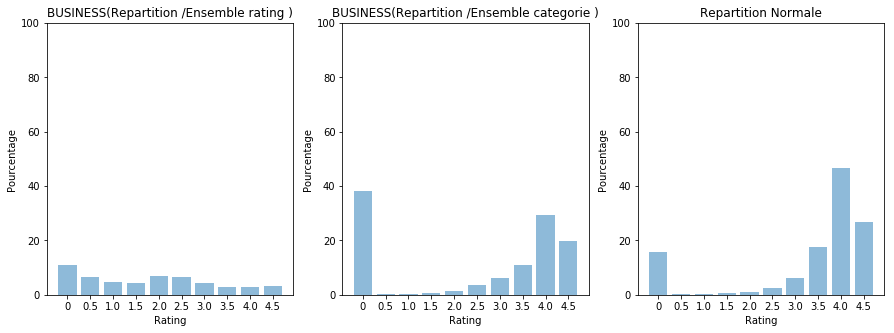

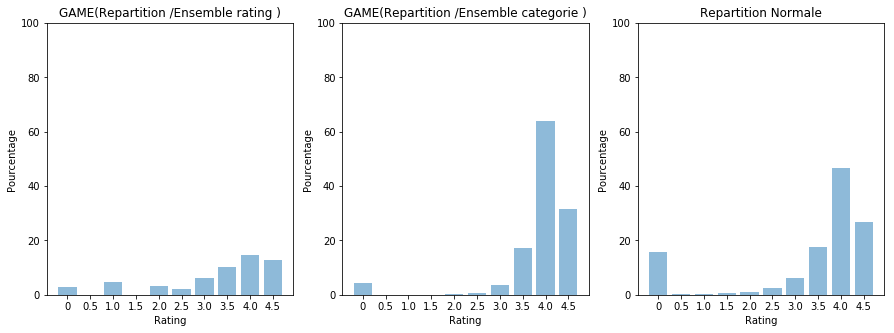

In [7]:
begin=0 #Début de l'intervalle
end = 5 #Fin de l'intervalle
step=0.5 #Pas de ségmentation des intervalles 
mapIntervalleNote={} #Dictionnaire des intervalles de notes
repartitionCategorie={} #Dictionnaire de la répartition des individu selon la catégorie et un intervalle de note
repartitionNote={}
repartitionGlobale={}
for i in range(int((end/step))): #Nombre de tour à effectuer afin d'avoir l'ensemble de la segmentation 
    intervalle=qualita[((qualita['Rating']>=begin) & (qualita['Rating']<= begin+step))] #On séléctionne l'intervalle de note 
    mapIntervalleNote[begin] = intervalle.drop(columns='Rating') #On retiens uniquement les colonnes qualitative de cette intervallle
    repartitionGlobale[begin] = (len(intervalle.index),len(qualita.index))#Répartition des note sur l'intervalle nombre d'individu sur l'intervalle de note / nombre total d'individu

    for col in intervalle.axes[1]:
        repartitionCategorie[begin,col] = (intervalle[col].sum(),(qualita[col].sum())) #Nombre d'individus qui posséde cette modalité sur l'intervalle / nombre total d'individu qui possède cette modaalité
        repartitionNote[begin,col]=(intervalle[col].sum(),len(intervalle.index))#Nombre d'individus qui posséde cette modalité sur l'intervalle / nombre total d'individu dans cette intervalle de note
    begin=begin+step
pourcentageRepartitionCatégorie={}
pourcentageRepartitionNote={}
pourcentageRepartitionGlobale={}
begin=0
for i in range((int(end/step))):
    for col in (mapIntervalleNote.get(0).axes[1]):
        value=repartitionCategorie[begin,col]
        value1=repartitionNote[begin,col]
        value2=repartitionGlobale[begin]
        pourcentageRepartitionCatégorie[begin,col]=(value[0]/value[1])*100
        pourcentageRepartitionNote[begin,col]=(value1[0]/value1[1])*100
        pourcentageRepartitionGlobale[begin] = (value2[0]/value2[1])*100
    begin=begin+step
begin=0
for col in (tabFinal.axes[1]): #Pour toutes les colonnes
    
    if(col in mapIntervalleNote[begin].axes[1]): #Si la colonne appartient au tri effectuer au-dessus
        
        x=[]
        y=[]
        y1=[]
        y2=[]
        for i in range(int(end/step)):
            valeur=pourcentageRepartitionCatégorie[begin,col]
            x.append(begin)
            y.append(valeur) #On ajoute le pourcentage de répartition catégorie afin le tracer de graphique
            y1.append(pourcentageRepartitionNote[begin,col])
            y2.append(pourcentageRepartitionGlobale[begin])
            begin=begin+step
        y_pos = np.arange(len(x)) #On récupére une array qui correspond à une suite allant de 0 au nombre d'intervalle
        plt.figure(figsize=(15,5)) #On définit la taille 15 par 5 pouce
        plt.subplot(1,3,1) #On définit 3 sous tracé 1 ligne 3 colonne
        plt.bar(y_pos, y1, align='center', alpha=0.5) #On trace notre premier graphique 
        plt.xticks(y_pos, x) #On place des trait en abscisse
        plt.ylabel('Pourcentage')
        plt.xlabel('Rating')
        plt.ylim(0,100)
        title(str(col)+ "(Repartition /Ensemble rating )")
        plt.subplot(1,3,2) 
        plt.bar(y_pos, y, align='center', alpha=0.5)
        plt.xticks(y_pos, x)
        plt.ylabel('Pourcentage')
        plt.xlabel('Rating')
        plt.ylim(0,100)
        title(str(col)+"(Repartition /Ensemble categorie )")
        plt.subplot(1,3,3)
        plt.bar(y_pos, y2, align='center', alpha=0.5)
        plt.xticks(y_pos, x)
        plt.ylabel('Pourcentage')
        plt.xlabel('Rating')
        plt.ylim(0,100)
        title("Repartition Normale")
        plt.show()
        begin=0
        
    
    

<p> Afin de confirmer le point biseral , nous avons décider de visualiser par rapport aux modalités conservées si effectivement elles ne suivaient pas la distrubution normale des applications par rapport aux notes , le code ci-dessus nous permet de représenter la présence de certaines modalités pour un intervalle de notes où l'on peut constater que 40% des applications Business ont des note comprises entre 0-0.5 ce qui represente 15% des applications qui on une note comprise entre 0-0.5 il est donc tres interessant de conserver cette modalité dans notre regression pour pouvoir appliquer un coefficient négatif pour les applications business et de la meme manière pour les application game 90% ont des note comprises entre 4 et 5 etoiles</p>

In [8]:
regr = linear_model.LinearRegression() 
regr.fit(tabFinal.drop(columns=fichier.columnExp),tabFinal[fichier.columnExp])
model = sm.OLS(tabFinal['Rating'],tabFinal.drop(columns='Rating')).fit() ##api statistique qui offre un modèle qui offre des statistiques sur notre modele
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     4539.
Date:                Thu, 30 May 2019   Prob (F-statistic):               0.00
Time:                        01:48:44   Log-Likelihood:                -17043.
No. Observations:                8738   AIC:                         3.410e+04
Df Residuals:                    8730   BIC:                         3.416e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Android Ver     0.8084      0.007    121.659      

<p>On constate que nous avons obtenus un R squared <strong>0.806</strong> ce qui est bon. On arrive a expliquer une bonne partie des points cependant nous avons remarqué que la variable install serait plus pertinente en tant que variable catégorielle notamment pour mieux expliquer les applications avec de faibles notes nous allons donc maintenant <strong>considérer le champs installation en tant que variable catégorielle</strong></p>

Auto & Vehicles:AUTO_AND_VEHICLES CORR:1.0
Books & Reference:BOOKS_AND_REFERENCE CORR:1.0
Business:BUSINESS CORR:1.0
Communication:COMMUNICATION CORR:1.0
Dating:DATING CORR:1.0
Events:EVENTS CORR:1.0
Finance:FINANCE CORR:1.0
Food & Drink:FOOD_AND_DRINK CORR:1.0
Paid:Free CORR:-1.0
Health & Fitness:HEALTH_AND_FITNESS CORR:1.0
House & Home:HOUSE_AND_HOME CORR:1.0
Libraries & Demo:LIBRARIES_AND_DEMO CORR:1.0
Lifestyle:LIFESTYLE CORR:0.9984243906706125
Maps & Navigation:MAPS_AND_NAVIGATION CORR:1.0
Medical:MEDICAL CORR:1.0
News & Magazines:NEWS_AND_MAGAZINES CORR:1.0
Personalization:PERSONALIZATION CORR:1.0
Photography:PHOTOGRAPHY CORR:1.0
Productivity:PRODUCTIVITY CORR:1.0
Shopping:SHOPPING CORR:1.0
Social:SOCIAL CORR:1.0
Sports:SPORTS CORR:0.9899547339735668
Tools:TOOLS CORR:1.0
Travel & Local:TRAVEL_AND_LOCAL CORR:0.9972057976641123
Video Players & Editors:VIDEO_PLAYERS CORR:0.995868926761201
Weather:WEATHER CORR:1.0
1+
1,000,000+
10+
10,000,000+
100+
100,000+
5+
5,000,000+
50+
500+
BUS

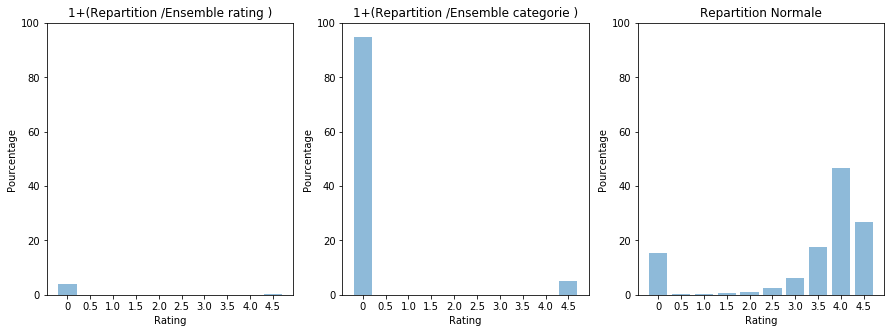

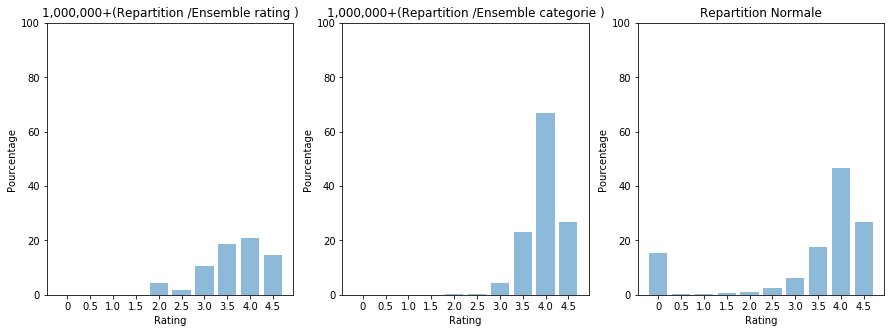

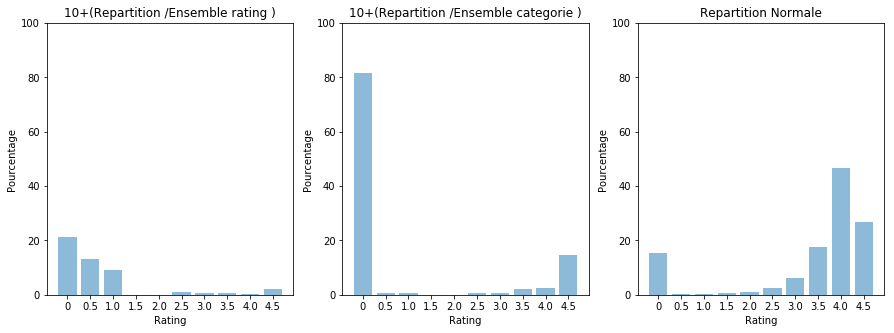

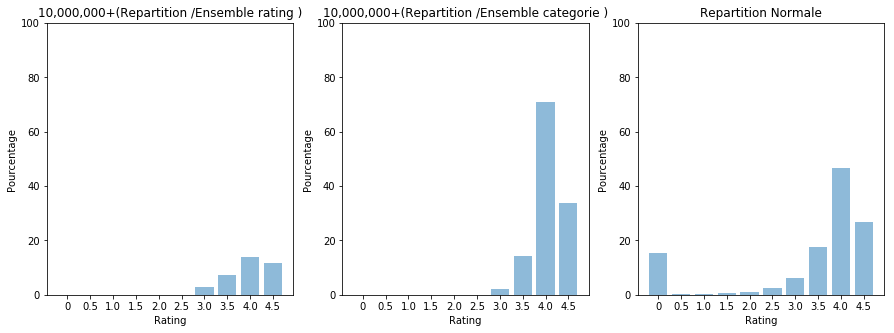

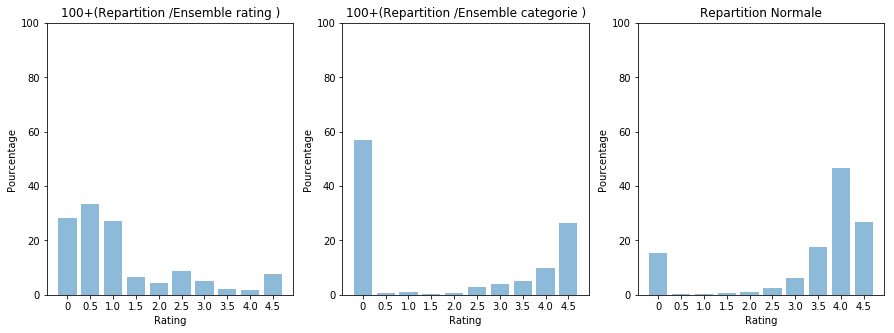

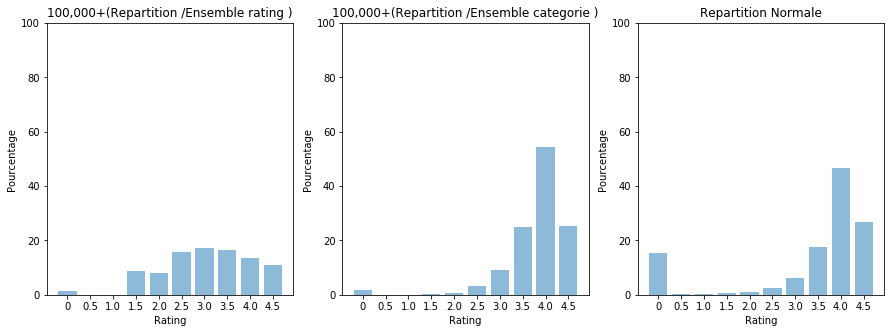

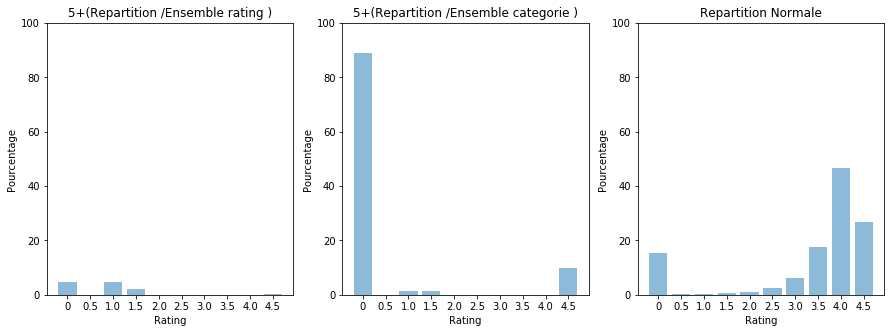

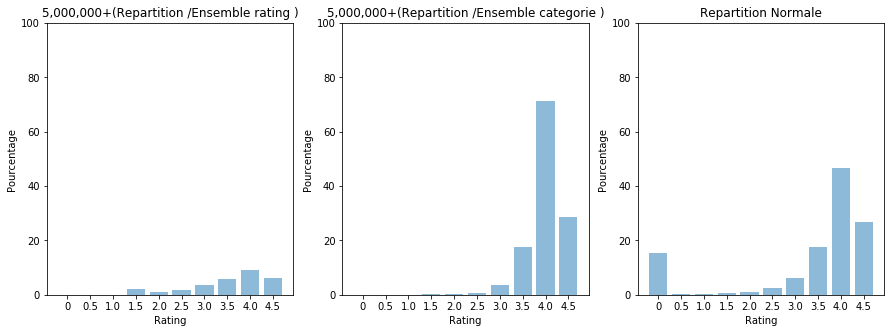

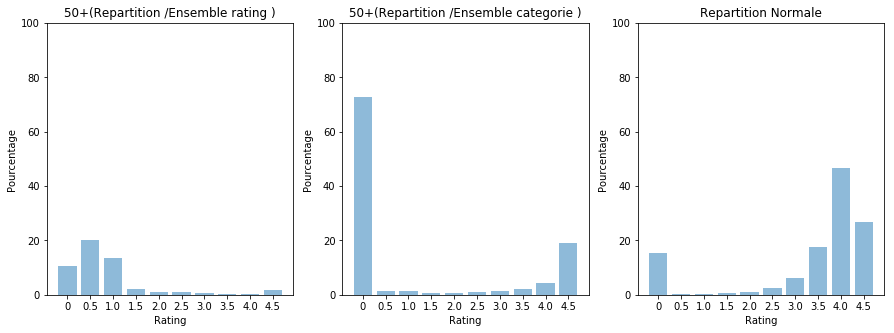

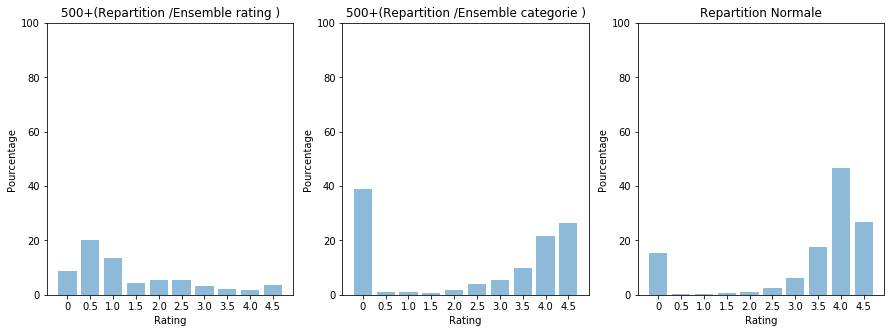

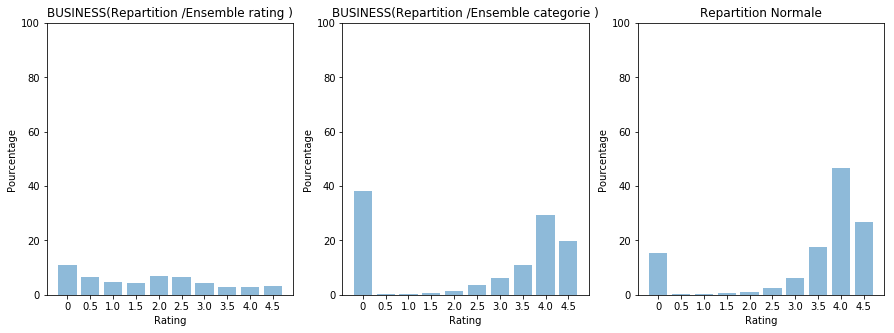

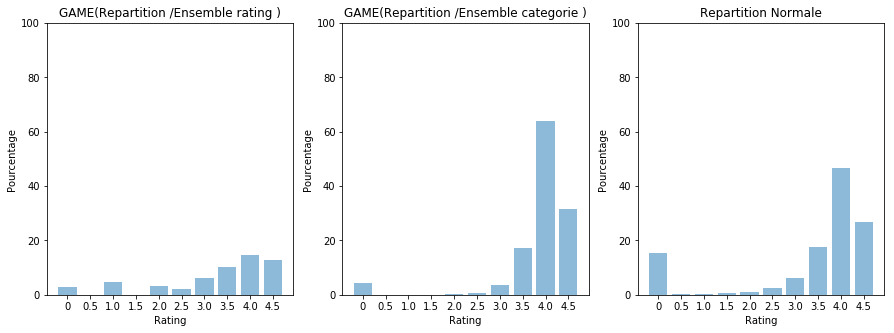

In [ ]:
##CODE IDENTIQUE A CELUI DU DESSUS MODIFICATION UNIQUEMENT SUR LES COLONNES RETENUE

fichier = csvToTab("googleplaystore.csv",",","Rating",["App"],["Android Ver","Current Ver","Reviews","Size","Price"],["Category","Content Rating","Genres","Type","Last Updated","Installs"])
tabFinal = fichier.getTabReady(False,200,60)
tabFinal = tabFinal.dropna()
tabCov = tabFinal.corr()
seuilCorr= 0.9
i=0
y=0
deleted = []
while(i < len(tabCov.axes[1])):
    while(y < len(tabCov.axes[1])) :
        if(abs(tabCov.iat[i,y]) > seuilCorr) :
            if(tabCov.axes[1][y] != tabCov.axes[0][i]) :
                if(not((tabCov.axes[1][y] in deleted) or (tabCov.axes[0][i] in deleted)) ):
                    deleted.append(tabCov.axes[1][y])
                    tabFinal = tabFinal.drop(columns=tabCov.axes[1][y],errors='ignore')
                    print(tabCov.axes[1][y] +":"+tabCov.axes[0][i]+ " CORR:"+str(tabCov.iat[i,y]))
        y=y+1
    y=0
    i=i+1
qualita = tabFinal.drop(columns=fichier.columnQuanta)
seuilCorr= 0.1
colonneConserver = []
for colonne in qualita.axes[1]:
    if(stats.pointbiserialr(qualita[colonne],tabFinal['Rating'])[0] > seuilCorr or stats.pointbiserialr(qualita[colonne],tabFinal['Rating'])[0] < -seuilCorr ):
        print(colonne)
        colonneConserver.append(colonne)
    else :
        tabFinal=tabFinal.drop(columns=colonne)
begin=0
end = 5
step=0.5
mapIntervalleNote={}
repartitionCategorie={}
repartitionNote={}
repartitionGlobale={}
for i in range(int((end/step))):
    intervalle=qualita[((qualita['Rating']>=begin) & (qualita['Rating']<= begin+step))]
    mapIntervalleNote[begin] = intervalle.drop(columns='Rating')
    repartitionGlobale[begin] = (len(intervalle.index),len(qualita.index))

    for col in intervalle.axes[1]:
        repartitionCategorie[begin,col] = (intervalle[col].sum(),(qualita[col].sum()))
        repartitionNote[begin,col]=(intervalle[col].sum(),len(intervalle.index))
    begin=begin+step
mapR={}
mapRR={}
mapRRR={}
begin=0
for i in range((int(end/step))):
    for col in (mapIntervalleNote.get(0).axes[1]):
        value=repartitionCategorie[begin,col]
        value1=repartitionNote[begin,col]
        value2=repartitionGlobale[begin]
        mapR[begin,col]=(value[0]/value[1])*100
        mapRR[begin,col]=(value1[0]/value1[1])*100
        mapRRR[begin] = (value2[0]/value2[1])*100
    begin=begin+step
begin=0
for col in (tabFinal.axes[1]):
    
    if(col in mapIntervalleNote[begin].axes[1]):
        
        x=[]
        y=[]
        y1=[]
        y2=[]
        for i in range(int(end/step)):
            valeur=mapR[begin,col]
            x.append(begin)
            y.append(valeur)
            y1.append(mapRR[begin,col])
            y2.append(mapRRR[begin])
            begin=begin+step
        y_pos = np.arange(len(x))
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.bar(y_pos, y1, align='center', alpha=0.5)
        plt.xticks(y_pos, x)
        plt.ylabel('Pourcentage')
        plt.xlabel('Rating')
        plt.ylim(0,100)
        title(str(col)+ "(Repartition /Ensemble rating )")
        plt.subplot(1,3,2)
        plt.bar(y_pos, y, align='center', alpha=0.5)
        plt.xticks(y_pos, x)
        plt.ylabel('Pourcentage')
        plt.xlabel('Rating')
        plt.ylim(0,100)
        title(str(col)+"(Repartition /Ensemble categorie )")
        plt.subplot(1,3,3)
        plt.bar(y_pos, y2, align='center', alpha=0.5)
        plt.xticks(y_pos, x)
        plt.ylabel('Pourcentage')
        plt.xlabel('Rating')
        plt.ylim(0,100)
        title("Repartition Normale")
        plt.show()
        begin=0



<p>On constate que de considérer le champ installation comme une variable catégorielle est pertinent car par exemple 80% des applications qui appartiennent a 10+ on une note de 0 et donc apparteniennent à cette catégorie ce qui va faire baisser la valeur du rating, ce qui est pertinent</p>

In [ ]:
##CODE IDENTIQUE A CELUI DU DESSUS MODIFICATION UNIQUEMENT SUR LES COLONNES RETENUE

regr.fit(tabFinal.drop(columns=fichier.columnExp),tabFinal[fichier.columnExp])
model = sm.OLS(tabFinal['Rating'],tabFinal.drop(columns='Rating')).fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     3273.
Date:                Thu, 30 May 2019   Prob (F-statistic):               0.00
Time:                        01:49:16   Log-Likelihood:                -15500.
No. Observations:                8747   AIC:                         3.103e+04
Df Residuals:                    8730   BIC:                         3.115e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
1+             -3.1717      0.187    -16.948      

<p>On constate que le R square s'est bien amélioré. Cependant il nous reste à retirer les variables quantitatives qui ne sont pas correlées avec le champ Rating</p>

In [ ]:
##CODE IDENTIQUE A CELUI DU DESSUS MODIFICATION UNIQUEMENT SUR LES COLONNES RETENUE
tabFinal = tabFinal.drop(columns=tabVariableAignorer)
regr.fit(tabFinal.drop(columns=fichier.columnExp),tabFinal[fichier.columnExp])
model = sm.OLS(tabFinal['Rating'],tabFinal.drop(columns='Rating')).fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     1055.
Date:                Thu, 30 May 2019   Prob (F-statistic):               0.00
Time:                        01:49:16   Log-Likelihood:                -19907.
No. Observations:                8747   AIC:                         3.984e+04
Df Residuals:                    8733   BIC:                         3.994e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
1+             -0.4378      0.307     -1.424      

<p>Malgré que le R square ait diminué de 0.2 , selon nous ce modele est plus pertinent car les variables ne servaient qu'à modéliser le bruit propre aux données d'entrainement</p><h3>En conclusion, faire une regression linéaire sur ce jeu de données est assez difficile. Et cela car peu de champs corrélaient avec le champ Rating , mais grace à la sur-representation d'application dans des catégories tels que les applications notées 0 dans la catégorie 10+ et le fait que le champ reviews est un minimum correlé avec le champ rating. Etant donné que la plupart des applications se situent dans un intervalle de notes, il serait peut etre plus judicieux d'effectuer une regression logistique multinomiale avec trois classes: mauvaise application , moyenne application , bonne application qu'on définirait selon un intervalle de notes</h3>


# PARTIE 2 STUDENTS PERFORMANCE IN EXAMS

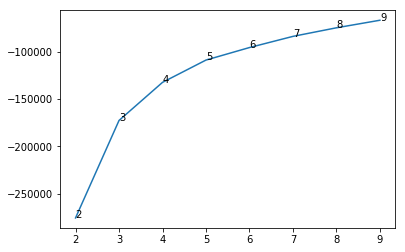

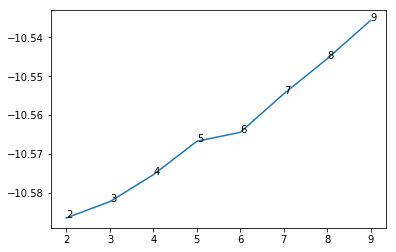

In [ ]:
a = csvToTab("StudentsPerformance.csv",",","",["gender","race/ethnicity","parental level of education","lunch","test preparation course"],["math score","reading score","writing score"],[])
tabFinal = a.getTabReady(False,200,60)
x=[]
y=[]
y1=[]
for i in range(2,10): #Pour un nombre de composant de 2 à 10
    kmeans = KMeans(n_clusters=i).fit(tabFinal) #On instancie l'algorithme kmean avec un nombre de centroid = à i
    gauss = mixture.GaussianMixture(n_components=i)#On instancie l'algorithme de mixture gaussienne avec un nombre de gaussienne = à i
    gauss.fit(tabFinal) #On entraine notre modele
    y.append(kmeans.score(tabFinal))#On ajoute le score de notre modele kmean afin d'effectuer le tracer par la suite 
    x.append(i)
    y1.append(gauss.score(tabFinal))#On ajoute le score de notre modele mixture gaussienne afin d'effectuer le tracer par la suite 
plt.plot(x,y)
for i_x,i_y in zip(x,y):
    plt.text(i_x,i_y,str(i_x))#Pour chaque point tracer on ajoute un label text qui correspond à son abscisse 

plt.show()
plt.plot(x,y1)
for i_x,i_y in zip(x,y1):
    plt.text(i_x,i_y,str(i_x))
plt.show()

<p>Pour ces deux algorithmes on considérera uniquement les variables continues etant donné que les deux algorithmes utilisent une distance par rapport à une moyenne. L'apport d'un codage binaire n'apporterai pas grand chose sauf si on normalise toutes les données entre 0-1 mais là non plus cela n'aurait pas énormement de sens de mettre au meme degre d'importance les notes et l'appartenance à une catégorie</p>

<p>On applique l'algorithme des k-mean sur le jeu de données qui permet de faire des groupements de points en fonction de centroide(calculée à partir de la moyenne de tous les point appartenant à ce centroide). L'algorithme cherche a minimiser la distance entre ces centroides et chaque point appartenant à ces centroide. L'algorithme de mixture gaussienne est en quelque sorte assez semblable au k-mean mais en moins brutal car chaque cluster correspondra à une gaussienne donc on prend en compte aussi un ecart type et une probabilité pour attribuer un point à un cluster ou un autre contrairemnt aux k-means qui ne tient en compte que de la distance par rapport aux centroides</p><br>

<p>Afin de choisir le nombre de clusters on utilise le critere d'Elbow tant que l'ajout d'un cluster explique une part importante du jeu de données alors on prend en compte cet ajout et lorsque l'ajout d'un cluster n'apporte plus beaucoup d'informations alors on s'arrete</p><br>
<img src="https://upload.wikimedia.org/wikipedia/commons/c/cd/DataClustering_ElbowCriterion.JPG" /><br>
<p>En effet si on prend comme exemple l'algorithme des k-mean on peut prendre comme k le nombre de points alors on aurait comme score une distance de 0(distance correspondant à la somme des distances des points par rapport à leur centroids) mais on perd l'interet d'utiliser un algorithme de clustering qui permet de rassembler les individus similaires </p>

<strong>Ici donc pour l'algorithmes k-mean ainsi que celui de la mixture gaussienne on va retenir un nombre de clusters de 4 </strong>



In [ ]:
kmeans = KMeans(n_clusters=4).fit(tabFinal) #On entraine notre algorithme aves nos donnée et un nombre de centroid = 4
gauss = mixture.GaussianMixture(n_components=4)
gauss.fit(tabFinal)#On entraine notre algorithme aves nos donnée et un nombre de gaussienne = 4
i=0 
individuWithLabel = {}
for label in kmeans.predict(tabFinal): #Retourne le cluster d'appartenance de chaque individu
    individuWithLabel[i] = label #On map chaque individu avec sont cluster d'appartenance 
    i=i+1
dataFrameLabel = {}
i=0
for individu in individuWithLabel: #Pour chaque individu
    try: #Si un dataframe existe pour le label de cette individu on l'ajoute à ce dataFrame
        dataFrameLabel[individuWithLabel[individu]] = dataFrameLabel[individuWithLabel[individu]].append(tabFinal.iloc[i])
    except KeyError : #Sinon on le crée est on l'ajoute
        dataFrameLabel[individuWithLabel[individu]]=pd.DataFrame()
        dataFrameLabel[individuWithLabel[individu]] = dataFrameLabel[individuWithLabel[individu]].append(tabFinal.iloc[i])

    i=i+1

<p>Afin de visualiser le clustering effectué par l'algorithme k-mean nous allons regrouper tous les individus avec un label identique et les mettre dans des dataframes isolés</p>

Label :0


,math score,reading score,writing score
0,72.0,72.0,74.0
4,76.0,78.0,75.0
5,71.0,83.0,78.0
12,65.0,81.0,73.0
13,78.0,72.0,70.0


math score: moyenne :71.36516853932584 Variance :54.801487577148265
reading score: moyenne :74.93820224719101 Variance :27.235606899825928
writing score: moyenne :73.99438202247191 Variance :29.425320462098433


Label :2


,math score,reading score,writing score
1,69.0,90.0,88.0
2,90.0,95.0,93.0
6,88.0,95.0,92.0
16,88.0,89.0,86.0
34,97.0,87.0,82.0


math score: moyenne :85.48924731182795 Variance :53.48366753850616
reading score: moyenne :88.83333333333333 Variance :34.56126126126126
writing score: moyenne :88.19354838709677 Variance :42.48125544899738


Label :3


,math score,reading score,writing score
3,47.0,57.0,44.0
7,40.0,43.0,39.0
9,38.0,60.0,50.0
11,40.0,52.0,43.0
17,18.0,32.0,28.0


math score: moyenne :44.78481012658228 Variance :93.07441747964204
reading score: moyenne :47.17088607594937 Variance :63.08526163025077
writing score: moyenne :44.78481012658228 Variance :61.32919454970572


Label :1


,math score,reading score,writing score
8,64.0,64.0,67.0
10,58.0,54.0,52.0
14,50.0,53.0,58.0
19,54.0,58.0,61.0
20,66.0,69.0,63.0


math score: moyenne :59.21739130434783 Variance :52.398891158447604
reading score: moyenne :61.86622073578595 Variance :27.136405467890768
writing score: moyenne :60.94314381270903 Variance :35.906152499382706




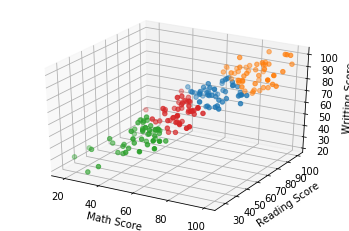

In [ ]:
dictPointLabel ={} #Dictionnaire des point qui vont etre représenter en dimension 3 selon leur label
for label in dataFrameLabel:
    print("Label :" + str(label)) #Affichage du label en cours de traitement
    display(HTML(dataFrameLabel[label].head(5).to_html())) #Affichage du dataframe sous format HTML
    dictPointLabel[label] = [dataFrameLabel[label].head(50)['math score'],dataFrameLabel[label].head(50)['reading score'],dataFrameLabel[label].head(50)['writing score']]#Ajout d'un certains nombre de point qui vont etre représenter par la suite  
    for col in dataFrameLabel[label].axes[1]: #Pour chaque dimentsion on calcule la moyenne et la variance et on affiche
        print(col +": moyenne :" + str(dataFrameLabel[label][col].mean()) + " Variance :" +str(dataFrameLabel[label][col].var()))
    print("\n")
fig = plt.figure() #Création d'une figure
ax = fig.add_subplot(111, projection='3d') #On ajoute a notre figure un subplot
ax.set_xlabel('Math Score')
ax.set_ylabel('Reading Score')
ax.set_zlabel('Writting Score')
for label in dictPointLabel:
    ax.scatter(dictPointLabel[label][0],dictPointLabel[label][1],dictPointLabel[label][2]) #On trace nos point 
plt.show()


<p>On constate que les individus étaient bien segmentés lors de l'execution aujourd'hui le <strong>Label 0</strong> correspond à des etudiants qui auront d'excellente note >85 le <strong>Label 1</strong> des etudiants plutot faible avec des notes de >30 à 50 , le <strong>label 3</strong> des etudaints moyen avec des notes >50 et inférieures à 70 et le <strong>Label2</strong> avec de bons éleves avec des notes >70 et inferieures à 90

In [ ]:
##CODE IDENTIQUE A CELUI DU DESSUS CHANGEMENT AVEC MIXTURE GAUSSIENNE
i=0
dictPointLabel ={}
individuWithLabel = {}
for label in gauss.predict(tabFinal):
    individuWithLabel[i] = label
    i=i+1
dataFrameLabel = {}
i=0
for individu in individuWithLabel:
    try:
        dataFrameLabel[individuWithLabel[individu]] = dataFrameLabel[individuWithLabel[individu]].append(tabFinal.iloc[i])
    except KeyError :
        dataFrameLabel[individuWithLabel[individu]]=pd.DataFrame()
    i=i+1

Label :0


,math score,reading score,writing score
4,76.0,78.0,75.0
5,71.0,83.0,78.0
8,64.0,64.0,67.0
12,65.0,81.0,73.0
13,78.0,72.0,70.0


math score: moyenne :68.97176470588235 Variance :58.371842397336536
reading score: moyenne :72.9835294117647 Variance :35.80869034406192
writing score: moyenne :72.29176470588236 Variance :33.82033296337405


Label :1


,math score,reading score,writing score
2,90.0,95.0,93.0
6,88.0,95.0,92.0
16,88.0,89.0,86.0
34,97.0,87.0,82.0
35,81.0,81.0,79.0


math score: moyenne :85.20975609756097 Variance :50.637159253945505
reading score: moyenne :87.8048780487805 Variance :41.68723098995693
writing score: moyenne :87.29268292682927 Variance :46.64921090387375


Label :3


,math score,reading score,writing score
9,38.0,60.0,50.0
10,58.0,54.0,52.0
11,40.0,52.0,43.0
14,50.0,53.0,58.0
19,54.0,58.0,61.0


math score: moyenne :55.13265306122449 Variance :67.84241136727724
reading score: moyenne :57.816326530612244 Variance :29.01051751758726
writing score: moyenne :55.802721088435376 Variance :35.913166631840426


Label :2


,math score,reading score,writing score
17,18.0,32.0,28.0
18,46.0,42.0,46.0
33,40.0,42.0,38.0
52,53.0,44.0,42.0
55,33.0,41.0,43.0


math score: moyenne :40.436619718309856 Variance :125.44949698189141
reading score: moyenne :40.478873239436616 Variance :43.653118712273645
writing score: moyenne :39.070422535211264 Variance :54.18068410462781




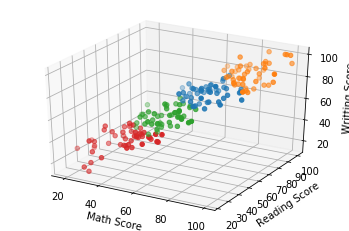

In [ ]:
##CODE IDENTIQUE A CELUI DU DESSUS CHANGEMENT AVEC MIXTURE GAUSSIENNE
for label in dataFrameLabel:
    print("Label :" + str(label))
    display(HTML(dataFrameLabel[label].head(5).to_html()))
    dictPointLabel[label] = [dataFrameLabel[label].head(50)['math score'],dataFrameLabel[label].head(50)['reading score'],dataFrameLabel[label].head(50)['writing score']]
    for col in dataFrameLabel[label].axes[1]:
        print(col +": moyenne :" + str(dataFrameLabel[label][col].mean()) + " Variance :" +str(dataFrameLabel[label][col].var()))
    print("\n")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Math Score')
ax.set_ylabel('Reading Score')
ax.set_zlabel('Writting Score')
for label in dictPointLabel:
    ax.scatter(dictPointLabel[label][0],dictPointLabel[label][1],dictPointLabel[label][2])
plt.show()

<p>On constate que les deux clusterings sont assez équivalents cependant que dans les cluster de la mixture gaussienne la variance est tres légerement plus élevée etant donné que l'attribution d'un individu à un cluster est moins strict qu'une simple distance par rapport à un centroid. Cependant ce n'est pas significatif pour ce jeu de données<p><br>
<p>Cependant parfois cela peut etre différent, exemple en image :</p>
<img src="https://i.stack.imgur.com/FAEfU.png" /><br>
<img src="https://i.stack.imgur.com/onXZr.png" /><br>



<h3>Ensuite, on cherchera à prédire si le « math score » est supérieur au score médian, en fonction des autres variables. Ca sera donc un problème de classification bi-classe: la classe 0 (math score inférieur au score médian) et la classe 1 (math score supérieur ou égal au score médian).</h3>

In [ ]:
class Element:
    def __init__(self,row,classe,primaryKey):
        self.row=row
        self.classe=classe
        self.id=primaryKey

Classe qui représente un individu lors d'un apprentissage supervisé <br>
Arguments du constructeur<br>
<b>row:</b><i> Attribut de l'individu</i><br>
<b>classe:</b><i> Classe à laquel appartient l'individu</i><br>
<b>primaryKey:</b><i> Identifiant unique de l'individu</i><br>

In [ ]:
class kproche:
    def __init__(self,number,setElement,nombreExtraction,tableauClasse):
        self.nombre=number #Nombre k 
        self.test=[] #Ensemble de test
        self.set=setElement #Ensemble de décision dex proches voisin
        self.tab=tableauClasse #Tableau des classe des individus
        for i in range(0,nombreExtraction): #Pour le nombre d'extraaction à effectuer
            entier=randint(0,len(self.set)) #On choisis un indivu au hasard dans notre ensemble de départ
            self.test.append(self.set[entier])#On l'ajoute dans notre ensemble de test
            del self.set[entier] #On le supprime de notre ensemble de départ
    def predict(self,point):
        dictDist={} #Map des distance entre le point à prédire est tout les autres 
        index=0
        for val in self.set: #Pour tous les individus 
            dictDist[index]=distance.euclidean(point,val.row) #On calcul la distance euclidienne entre cette individu et le point qu'on cherche à prédire
            index=index+1
        sorted_x = sorted(dictDist.items(), key=lambda tupl: tupl[1]) #On trie nos distance par rapprot aux distance
        dictionnaireVote = {} #Dictionnaire qui représente le nombre de "vote" des voisin pour savoir quelle classe est majoritaire chez les voisin
        for classe in self.tab: #Pour chaque classe de nos individus
            dictionnaireVote[classe]=0 #On initialise à 0 le nombre de vote de chaque classe
            
        for i in range(0,self.nombre): #Pour le nombre de voisin
            for classe in self.tab:
                if (self.set[sorted_x[i][0]].classe == classe): #Si l'individu i le  plus proche(o as trier sorted_x) appartient à cette classe on incremente le nombre de vote
                    dictionnaireVote[classe] = dictionnaireVote[classe] + 1 
        
        sorted_x = sorted(dictionnaireVote.items(), key=lambda tupl: tupl[1],reverse=True) #On trie nos vote de facon décroissante pour retenir la classe qui as le plus de vote 
        return(sorted_x[0][0]) #On renvoie la premiere valeur du tableau qui correpond à la classe ayant eu le plus de vote 
    def score(self):
        vrai = 0
        if(len(self.test) == 0):#Si on as constituer un ensemble de test
            for element in self.set: #Pour tous les individu test
                classe = self.predict(element.row) #On prédit la classe d'appartenance de cette individu
                if(classe == element.classe): #Si la classe prédite correspond bien à la classe de l'individu on incremente la variable vrai
                    vrai=vrai+1
            return vrai/len(self.set)
        else:
            for element in self.test:
                classe = self.predict(element.row)
                if(classe == element.classe):
                    vrai=vrai+1
            return vrai/len(self.test)
            
            
        

Classe qui nous permet d'instancier l'algorithme des k-proche
Elle effectue un prelévement automatique parmi le jeu d'entrainement (les suppriment du jeu d'entrainement) afin par la suite d'effectuer des tests de scoring<br>
Arguments du constructeur<br>
<b>number:</b><i>Nombre k choisi</i><br>
<b>setElement:</b><i>Ensemble d'elements de notre ensemble d'entrainement(type Element ci-dessus)</i><br>
<b>nombreExtraction:</b><i>Nombre d'extractions à effectuer de notre ensemble d'elements de départ afin de constituer un ensemble de tests différents de celui d'entrainement</i><br>
<b>tableauClasse:</b><i>Tableau de l'ensemble des classes de notre ensemble d'entrainements</i><br>
<h3>Méthodes</h3>
<li><b>predict:</b> Méthode qui permet de prédire l'appartenance d'un individu à une certaine classe en regardant ses k plus proches voisins. La classe d'appartenance de cet individu sera la classe majoritaire de ses voisins</li>
<li><b>score:</b> Méthode qui permet de connaitre sur l'ensemble de test et non d'entrainement le taux de bonnes predictions compris entre 0 et 1</li>
<h4>Arguments des méthodes</h4>
<table>
    <thead>
        <tr>
            <th>Arguments</th>
            <th>METHODES : predict</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>point</td>
            <td>Individu sur lequel il faut déterminer la classe d'appartenance</td>
        </tr>
    </tbody>
</table>


In [ ]:
a = csvToTab("StudentsPerformance.csv",",","math score",["gender","race/ethnicity","parental level of education","lunch","test preparation course"],["reading score","writing score"],[])
tab = a.getTabReady(False,200,60)
tab = tab.drop(columns=a.columnExp)
mediane = a.data[a.columnExp].median()
classeElement=[]
index=0
pointXBlue = []
pointYBlue = []
pointXRed = []
pointYRed = []
for values in a.data[a.columnExp]: #Pour toutes les valeurs de la colonne a expliqquer
    if(values>mediane): #Si la valeur est supérieur à la médiane on attribue cette individu a la classe 1 et on ces coordonées pour un affichage
        
        classeElement.append(Element(tab.loc[index],1,index))
        a.data.at[index,a.columnExp]=1
        pointXRed.append(a.data.at[index,'reading score'])
        pointYRed.append(a.data.at[index,'writing score'])
        
        
    else: #Sinon on l'attribue à la classe 0 
        classeElement.append(Element(tab.loc[index],0,index))
        a.data.at[index,a.columnExp]=0
        pointXBlue.append(a.data.at[index,'reading score'])
        pointYBlue.append(a.data.at[index,'writing score'])

    index=index+1
x=[]
yMoi=[]
for i in range(1,20) :
    x.append(i)
    neigh = KNeighborsClassifier(n_neighbors=i).fit(tab.tail(700),a.data[a.columnExp].tail(700)) #On instancie l'algorithme de k-meaan de scikit avec i voisin
    moi=kproche(i,classeElement.copy(),100,[0,1])#On instancie notre algorithme avec i voisin
    mScore = moi.score()
    sScore=neigh.score(tab.head(100),a.data[a.columnExp].head(100))
    yMoi.append(mScore)
    print("Score de mon algorithme :" + str(mScore) + " Nombre Voisin :" + str(i))
    print("Score de scikit :" + str(sScore)+ " Nombre Voisin :" + str(i) + "\n")


Score de mon algorithme :0.74 Nombre Voisin :1
Score de scikit :0.72 Nombre Voisin :1

Score de mon algorithme :0.75 Nombre Voisin :2
Score de scikit :0.79 Nombre Voisin :2

Score de mon algorithme :0.8 Nombre Voisin :3
Score de scikit :0.79 Nombre Voisin :3

Score de mon algorithme :0.77 Nombre Voisin :4
Score de scikit :0.79 Nombre Voisin :4

Score de mon algorithme :0.72 Nombre Voisin :5
Score de scikit :0.82 Nombre Voisin :5

Score de mon algorithme :0.76 Nombre Voisin :6
Score de scikit :0.83 Nombre Voisin :6

Score de mon algorithme :0.77 Nombre Voisin :7
Score de scikit :0.81 Nombre Voisin :7

Score de mon algorithme :0.75 Nombre Voisin :8
Score de scikit :0.84 Nombre Voisin :8

Score de mon algorithme :0.76 Nombre Voisin :9
Score de scikit :0.83 Nombre Voisin :9

Score de mon algorithme :0.69 Nombre Voisin :10
Score de scikit :0.83 Nombre Voisin :10

Score de mon algorithme :0.77 Nombre Voisin :11
Score de scikit :0.83 Nombre Voisin :11

Score de mon algorithme :0.75 Nombre Voi

<p>On constate que les point doivent bien etre répartis dans l'espace car le taux d'erreur est de 15/100 en moyenne <strong>avec un tirage aléatoire d'elements qui n'ont pas participé à l'entrainement du modèle</strong> il n'y a donc pas de "faux vote"  c'est à dire la prédiction d'un point deja existant dans notre modèle,cela sous entend que les deux ensembles sont bien répartis dans l'espace. La note obtenue en reading et writing est bien discriminante pour savoir si l'etudiant a obtenu une note en maths > à la médiane ou pas. Le nombre de voisins influe sur la qualité du modèle, on peut jouer sur ce nombre de voisin pour adapter la sensibilité des individus situer à la frontiere des deux ensembles.

In [ ]:
plt.plot(x,yMoi)
for i_x,i_y in zip(x,yMoi):
    plt.text(i_x,i_y,str(i_x))
plt.show()

<p>On constate que le choix du nombre k de voisins n'est pas évident il doit y avoir des points à la frontière des deux ensembles qui se melent</p>

In [ ]:
plt.plot(pointXBlue,pointYBlue,'bo',pointXRed,pointYRed,'ro',markersize=3)
plt.plot([65,65], [0, 100], 'g-', lw=2)
plt.show()

<p>On constate que les points sont bien répartis, à partir de 65 on constate une forte densité d'etudiants avec une note en maths supérieure à la médiane et avant une forte densité d'étudiants avec une note en maths inférieure à la médiane</p> <p>Cet algorithme est performant pour ce jeu de données cependant il a une forte complexité étant donné qu'il faut à chaque nouvelle donnée, déterminer les plus proche voisins. Le jeu d'entrainement ne doit pas trop etre important en terme de données</p>

In [ ]:
class BayesienNaif :
    def __init__(self,setElement,nombreExtraction,tableauClasse):
        self.test=[]
        self.set=setElement

        for i in range(0,nombreExtraction):
            entier=randint(0,len(setElement)) #Meme fonctionnement que la classe k-proche
            self.test.append(setElement[entier])
            del setElement[entier]
        dictProbClasse = {}
        nbElementClasse= {}
        self.classe=tableauClasse
        for classe in tableauClasse:
            dictProbClasse[classe]=0
        for classe in tableauClasse: #Pour chaque classe
            for element in setElement:
                if(element.classe==classe):
                    dictProbClasse[classe] =  dictProbClasse[classe] + 1 #Nombre d'individu appartenant à cette classe
        for classe in tableauClasse:
            nbElementClasse[classe]=dictProbClasse[classe] #Nombre d'individus dans chaque classe
            dictProbClasse[classe]=dictProbClasse[classe]/len(setElement) #Propabilité d'appartenir à cette classe
        dictProbCaraSachantClasse = {}
        for cara in setElement[0].row.index:
            for classe in tableauClasse:
                dictProbCaraSachantClasse[cara,classe] = 0 #Pour chaque modalité appartenant à une classe on initialise à 0
        for classe in tableauClasse:
            for element in setElement:
                for cara in element.row.index:
                    if(element.classe == classe): #Si l'element appartient à la classe
                        dictProbCaraSachantClasse[cara,classe] = dictProbCaraSachantClasse[cara,classe] + element.row[cara] #On ajoute 1 ou 0 si l'individu pour cette classe à la modalite ou pas 
                    else:
                        break #Si l'individu n'appartient pas a la classe on passe à l'individu suivant 
        for car,classe in dictProbCaraSachantClasse:
            dictProbCaraSachantClasse[car,classe] = dictProbCaraSachantClasse[car,classe]/nbElementClasse[classe] #On divisse le nombre d'individu pour cette modalité et cette classe / le nombre d'individu dans cette classe afin d'obtenir la probabilité conditionnelle
        self.dictProbCara = dictProbCaraSachantClasse
        self.dictProbClasse = dictProbClasse
    def predict(self,element):
        dictProbAppart = {}
        for classe1 in self.classe:
            dictProbAppart[classe1]=1
            for cara in element.row.index:
                if(element.row[cara] == 1):
                    dictProbAppart[classe1]=dictProbAppart[classe1]*(self.dictProbCara[cara,classe1])#On effectue le produit de toutes les probabilité conditionnelle de cette individu
                dictProbAppart[classe1] = dictProbAppart[classe1]*self.dictProbClasse[classe1]#On multiplie par la propabilité d'appartennir à la classe

        best = -1 #Initialisation de la meilleur probabilité (toutes les probabilité seront supérieur ou égale a 0)
        returnV=99
        for classe in dictProbAppart:
            if(best < dictProbAppart[classe]): #Si une meilleur probabilité
                best = dictProbAppart[classe]
                returnV=classe
        return returnV #Classe la plus probable
    def score(self):#Meme fonctionnement que la classe k-proche
        vrai = 0
        if(len(self.test) == 0):
            for element in self.set:
                classe = self.predict(element)
                
                if(classe == element.classe):
                    vrai=vrai+1
            return vrai/len(self.set)
        else:
            for element in self.test:
                classe = self.predict(element)
                if(classe == element.classe):
                    vrai=vrai+1
            return vrai/len(self.test)

Classe qui nous permet d'instancier l'algorithmes Bayesien Naif sur des variables catégorielles. Elle effectue un prelévement automatique parmi le jeu d'entrainement (les suppriment du jeu d'entrainement) afin par la suite d'effectuer des tests de scoring<br>
Arguments du constructeur<br>
<b>setElement:</b><i>Ensemble d'elements de notre ensemble d'entrainement(type Element ci-dessus)</i><br>
<b>nombreExtraction:</b><i>Nombre d'extractions à effectuer de notre ensemble d'elements de départ afin de constituer un ensemble de tests différents de celui d'entrainement</i><br>
<b>tableauClasse:</b><i>Tableau de l'ensemble des classes de notre ensemble d'entrainements</i><br>
<h3>Méthodes</h3>
<li><b>predict:</b> Méthode qui permet de prédire l'appartenance d'un individu à une certaine classe en maximisant la probabilité d'appartenance à cette classe selon ses caractéristiques</li>
<li><b>score:</b> Méthode qui permet de connaitre sur l'ensemble de tests et non d'entrainement le taux de bonnes predictions compris entre 0 et 1</li>
<h4>Arguments des méthodes</h4>
<table>
    <thead>
        <tr>
            <th>Arguments</th>
            <th>METHODES : predict</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>element</td>
            <td>Individu surlequel il faut déterminer la classe d'appartenance</td>
        </tr>
    </tbody>
</table>


<p>Cette classe nous permet de calculer les <strong>propabilitées conditionelles</strong> des modalités des variables catégorielles par rapport à la classe d'appartennance, ainsi que les probabilités d'appartenance à chacune des classes, ensuite la prédiction sélectionne la propabilité de la plus haute appartenance à une classe n selon les caracteristiques d'un individu qui pour cette seront suposées <strong>indépendantes</strong></p><br>
<p>A partir du théorème de Bayes la probabilité d'appartenir à la classe y sachant les caractéristique Xi équivaut à :</p>
\begin{align}P(y \mid x_1, \dots, x_n) = \frac{P(y) \prod_{i=1}^{n} P(x_i \mid y)}
                                 {P(x_1, \dots, x_n)}\end{align}
<p>Etant donnée que le dénominateur ne dépend que des caractéristiques on peut l'omettre de l'équation car on peut le considérer comme une constante qui ne nous intéresse pas dans notre problème de maximisation , ce qui revient à trouver l'argument y qui maximise : </p>
\begin{align}\begin{aligned}P(y \mid x_1, \dots, x_n) \propto P(y) \prod_{i=1}^{n} P(x_i \mid y)\\\Downarrow\\\hat{y} = \arg\max_y P(y) \prod_{i=1}^{n} P(x_i \mid y),\end{aligned}\end{align}

In [ ]:
##MEME FONCTIONNEMENT QUE CELLULE 57

a = csvToTab("StudentsPerformance.csv",",","math score",["reading score","writing score"],[],["gender","race/ethnicity","parental level of education","lunch","test preparation course"])
tab = a.getTabReady(False,200,60)
tab = tab.drop(columns=a.columnExp)
mediane = a.data[a.columnExp].median()
classeElement=[]
index=0

for values in a.data[a.columnExp]:
    if(values>mediane):
        classeElement.append(Element(tab.loc[index],1,index))
        a.data.at[index,a.columnExp]=1
    else:
        classeElement.append(Element(tab.loc[index],0,index))
        a.data.at[index,a.columnExp]=0
    index=index+1

moi=BayesienNaif(classeElement.copy(),0,[0,1])
gnb = GaussianNB()
gnb.fit(tab,a.data[a.columnExp])
mScore = moi.score()
sScore=gnb.score(tab,a.data[a.columnExp])
print("Score de mon algorithme :" + str(mScore))
print("Score de scikit :" + str(sScore)+ "\n")


<p>Nous constatons que ce modèle n'est pas du tout adapté car il arrive seulement à prédire la classe d'appartenance à seulement 64% , etant donné que nous sommes dans un modèle bi-classe c'est légerement mieux que le hasard qui est de 50% étant donné que la médiane a scindé la population en 2</p>
<p>On peut expliquer cela par le fait que les variables catégorielles ne sont pas discriminantes pour savoir à quelle classe appartient l'individu autrement dit P(X|0) ~ P(X|1) la probabilité d'appartenir à la classe 0 sachant X est pratiquement équivalente à la probabilité d'appartenir à la classe 1 sacahant X</p>

In [ ]:
for modalite,classe in moi.dictProbCara: #Affichage des probabilité condictionnelle sachant la classe d'appartenance
    print(str("P("+modalite + "|" + str(classe) + ")"+ "=" + str(moi.dictProbCara[modalite,classe])))

<p>On constate effectivement que les probabilités différent peu si on appartient à la classe 0 ou 1 ce qui explique la faible qualité du modèles</p>

In [ ]:
class GaussianNaiveBayes :
    def __init__(self,setElement,nombreExtraction,tableauClasse):
        self.test=[]
        self.set=setElement
        for i in range(0,nombreExtraction):
            entier=randint(0,len(setElement)) #Meme fonctionnement que la classe k-proche
            self.test.append(setElement[entier])
            del setElement[entier]
        dictProbClasse = {}
        nbElementClasse= {}
        self.classe=tableauClasse
        for classe in tableauClasse:
            dictProbClasse[classe]=0
        for classe in tableauClasse:
            for element in setElement:
                if(element.classe==classe):
                    dictProbClasse[classe] =  dictProbClasse[classe] + 1 #Meme fonctionnement que la classe Naive bayes
        for classe in tableauClasse:
            nbElementClasse[classe]=dictProbClasse[classe]
            dictProbClasse[classe]=dictProbClasse[classe]/len(setElement)
        dictDataClasse = {}
        for classe in tableauClasse : #Création d'un dataframe par classe
            dictDataClasse[classe] = pd.DataFrame()
        for element in setElement:
            for classe in tableauClasse:
                if(element.classe == classe):
                    dictDataClasse[classe] = dictDataClasse[classe].append(element.row) #Ajout des individu dans le dataframe qui correspond à leur classe
                    break
        dictProbCaraSachantClasse = {}
        for classe in tableauClasse:
            for cara in setElement[0].row.index:
                dictProbCaraSachantClasse[cara,classe] = (dictDataClasse[classe][cara].mean(),dictDataClasse[classe][cara].var()) #Pour chaque colonne en fonction de la classe on calcul la moyenne et la variance
        self.dictProbCara = dictProbCaraSachantClasse
        self.dictProbClasse = dictProbClasse
    def predict(self,element):
        dictProbAppart = {}
        for classe1 in self.classe:
            dictProbAppart[classe1]=1
            for cara in element.row.index:
                numerateur=math.exp(-(element.row[cara] - self.dictProbCara[cara,classe1][0])**2/(2*self.dictProbCara[cara,classe1][1])) #On applique la formule de la distribution gaussienne afin d'obtenir la probabilité
                denomi=(math.sqrt((2*math.pi*self.dictProbCara[cara,classe1][1])))
                dictProbAppart[classe1]=dictProbAppart[classe1]*(numerateur/denomi) #On effectue le produit comme dans la formule ci-dessus

                    
            dictProbAppart[classe1] = dictProbAppart[classe1]*self.dictProbClasse[classe1]
        best = -1
        returnV=99 ##Meme fonctionnement que naif bayes
        for classe in dictProbAppart:
            if(best < dictProbAppart[classe]):
                best = dictProbAppart[classe]
                returnV=classe
        return returnV
    def score(self):
        vrai = 0
        if(len(self.test) == 0):
            for element in self.set:
                classe = self.predict(element)
                
                if(classe == element.classe):
                    vrai=vrai+1
            return vrai/len(self.set)
        else:
            for element in self.test:
                classe = self.predict(element)
                if(classe == element.classe):
                    vrai=vrai+1
            return vrai/len(self.test)    


Classe qui nous permet d'instancier l'algorithme gaussian naive bayes sur des variables continues. 
On modélise les probabilités d'appartenance à l'aide d'une loi normale, et effectue un prelévement automatique parmi le jeu d'entrainement (les suppriment du jeu d'entrainement) afin par la suite d'effectuer des test de scoring<br>
Arguments du constructeur<br>
<b>setElement:</b><i>Ensemble d'elements de notre ensemble d'entrainement(type Element ci-dessus)</i><br>
<b>nombreExtraction:</b><i>Nombre d'extraction à effectuer de notre ensemble d'elements de départ afin de constituer un ensemble de tests différents de celui d'entrainement</i><br>
<b>tableauClasse:</b><i>Tableau de l'ensemble des classes de notre ensemble d'entrainements</i><br>
<h3>Méthodes</h3>
<li><b>predict:</b>  Méthode qui permet de prédire l'appartenance d'un individu à une certaine classe en maximisant la porbabilité d'appartenance à cette classe selon ces caractéristiques</li>
<li><b>score:</b> Méthode qui permet de connaire sur l'ensemble de test et non d'entrainements le taux de bonnes predictions compris entre 0 et 1</li>
<h4>Arguments des méthodes</h4>
<table>
    <thead>
        <tr>
            <th>Arguments</th>
            <th>METHODES : predict</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>element</td>
            <td>Individu sur lequel il faut déterminer la classe d'appartenance</td>
        </tr>
    </tbody>
</table>

<p>A partir du théorème de Bayes la probabilité d'appartenir à la classe y sachant les caractéristique Xi équivaut à :</p>
\begin{align}P(y \mid x_1, \dots, x_n) = \frac{P(y) \prod_{i=1}^{n} P(x_i \mid y)}
                                 {P(x_1, \dots, x_n)}\end{align}
<p>Etant donnée que le dénominateur ne dépend que des caractéristique on peut l'omettre de l'équation car on peut le considérer comme une constante qui ne nous intéresse pas dans notre problèmes de maximisation , ce qui revient à trouver l'argument y qui maximise : </p>
\begin{align}\begin{aligned}P(y \mid x_1, \dots, x_n) \propto P(y) \prod_{i=1}^{n} P(x_i \mid y)\\\Downarrow\\\hat{y} = \arg\max_y P(y) \prod_{i=1}^{n} P(x_i \mid y),\end{aligned}\end{align}

<p>Etant donné qu'ici nous avons des variables continues nous obtenons la propabilités d'obtenir la valeur xi en sachant qu'on appartient à la classe C à l'aide d'une distribution gaussienne : </p>
<img src="https://cdn-images-1.medium.com/max/1600/1*I8NyhErPvQ_IbU5wzJl5UA.png" /><br>
<p>Donc pour chaque dimension de notre problème nous déterminons la moyenne et la variance de chaque gaussienne</p>


In [ ]:
##MEME FONCTIONNEMENT QUE CELLULE 57
a = csvToTab("StudentsPerformance.csv",",","math score",["gender","race/ethnicity","parental level of education","lunch","test preparation course"],["reading score","writing score"],[])
tab = a.getTabReady(False,200,60)
tab = tab.drop(columns=a.columnExp)
mediane = a.data[a.columnExp].median()
classeElement=[]
index=0

for values in a.data[a.columnExp]:
    if(values>mediane):
        
        classeElement.append(Element(tab.loc[index],1,index))
        a.data.at[index,a.columnExp]=1
        
    else:
        classeElement.append(Element(tab.loc[index],0,index))
        a.data.at[index,a.columnExp]=0
        
    index=index+1
algo=GaussianNaiveBayes(classeElement.copy(),0,[0,1])
gnb = GaussianNB()
gnb.fit(tab,a.data[a.columnExp])
sScore=gnb.score(tab,a.data[a.columnExp])
mScore=algo.score()
print("Score de mon algorithme :" + str(mScore))
print("Score de scikit :" + str(sScore)+ "\n")
    

<p>On constate que ce modèle de Bayes est beaucoup plus efficace que celui qui fonctionne sur les variables catégorielles, cela signifie que nos deux variables continues sont plus discrimiantes que les variables catégorielles precedentes , les gaussienne associées à chaque classe permettent de définir des probabilitées d'appartance sensiblement différentes à la classe 1 ou 0   </p>  

In [ ]:
tabMoyenne = []
tabVariance = []
tabNom = {}
y=0
for categorie,classe in algo.dictProbCara: #On récupere la moyenne et varaince de chaque colonne en fonction de la classe
    tabNom[y] = categorie 
    moyenne=algo.dictProbCara[categorie,classe][0]
    variance=algo.dictProbCara[categorie,classe][1]
    tabMoyenne.append(moyenne)
    tabVariance.append(variance)
    y=y+1
i=0
nbCategorie=len(tab.axes[1])
while ( i < len(tabMoyenne)/2):
    moyenne=tabMoyenne[i]
    variance=tabVariance[i]
    moyenneClasseSuivante=tabMoyenne[i+nbCategorie]
    varianceClasseSuivante=tabVariance[i+nbCategorie]
    ecartType1 = math.sqrt(variance)
    ecartType2 = math.sqrt(varianceClasseSuivante)
    ##On affiche les distribution gaussienne en fonction des catégories et des classe
    x1 = np.linspace(moyenne - 3*ecartType1, moyenne + 3*ecartType1, 100)
    x2 = np.linspace(moyenneClasseSuivante - 3*ecartType2, moyenneClasseSuivante + 3*ecartType2, 100)
    plt.plot(x1, stats.norm.pdf(x1, moyenne, ecartType1),label='Note Math < 50')
    plt.plot(x2, stats.norm.pdf(x2, moyenneClasseSuivante, ecartType2),label='Note Math > 50')
    plt.title('Catégorie : '   + tabNom[i])
    plt.legend(loc='upper left')
    plt.show()
    i=i+1
    

<p>On constate que les deux gaussiennes sont bien discrimantes jusqu'à un certain point: les étudiants qui ont une note entre 30 et 55 ont une tres forte probabilitée d'avoir obtenue une inférieure à 50 en maths et les étudiants qui ont obtenue une note >80 ont une très forte probabilité d'avoir obtenue une note > 50 en maths. On constate aussi  que l'ecart type des personnes qui ont obtenu une note >50 est plus faible que ceux qui ont obtenu une note inférieure à 50 cela s'explique par le fait que les étudiants qui ont obtenu une note >50 en math ont pour la plupart aussi obtenu de bonnes notes en reading et writing , et pour terminer on constate que les distributions de gaussiennes selon les catégories sont extrêmement équivalentes donc on peut réduire notre modèle à une des deux , car une dimension est <strong>redondante</strong> ici</p> 

In [ ]:
##MEME FONCTIONNEMENT QUE CELLULE 57
a = csvToTab("StudentsPerformance.csv",",","math score",["gender","race/ethnicity","parental level of education","lunch","test preparation course","reading score"],["writing score"],[])
tab = a.getTabReady(False,200,60)
tab = tab.drop(columns=a.columnExp)
mediane = a.data[a.columnExp].median()
classeElement=[]
index=0

for values in a.data[a.columnExp]:
    if(values>mediane):
        
        classeElement.append(Element(tab.loc[index],1,index))
        a.data.at[index,a.columnExp]=1
        
    else:
        classeElement.append(Element(tab.loc[index],0,index))
        a.data.at[index,a.columnExp]=0
        
    index=index+1
algo=GaussianNaiveBayes(classeElement.copy(),0,[0,1])
mScore=algo.score()
print("Score de mon algorithme :" + str(mScore))

    

En ne conservant qu'une seule dimension on constate que le score est bien équivalent

In [ ]:
#Meme fonctionnement que pour la régression linéaire partie 1 
a = csvToTab("StudentsPerformance.csv",",","math score",[],["writing score","reading score"],["gender","race/ethnicity","parental level of education","lunch","test preparation course"])
tab = a.getTabReady(False,200,60)

On conserve les colonnes quantitatives ainsi que les continues étant donné que pour la régression il y a un intérêt à cela

In [ ]:
#Meme fonctionnement que pour la régression linéaire partie 1 

quanta = tab.filter(items=a.columnQuanta)
quantaWithRating= quanta.corrwith(tab['math score'])
qunataWithQuanta=quanta.corr()
quantaWithRating.plot.bar()
qunataWithQuanta.plot.bar()
mediane = a.data[a.columnExp].median()
index=0
##On assigne chaque individu à sa classe d'appartenance
for values in a.data[a.columnExp]:
    if(values>mediane):
        classeElement.append(Element(tab.loc[index],1,index))
        a.data.at[index,a.columnExp]=1
    else:
        classeElement.append(Element(tab.loc[index],0,index))
        a.data.at[index,a.columnExp]=0
    index=index+1

On constate que les deux colonnes quantitatives sont extrêmement corrélées avec le champ math score donc il faut les conserver pour notre régression , mais elles sont également extrêmement corélées entre-elles donc on ne conservera qu'une seule des deux car si on prend les deux il y aura redondance

In [ ]:
#Meme fonctionnement que pour la régression linéaire partie 1 

tabCov = tab.corr()
seuilCorr= 0.9
i=0
y=0
deleted = []
while(i < len(tabCov.axes[1])):
    while(y < len(tabCov.axes[1])) :
        if(abs(tabCov.iat[i,y]) > seuilCorr) :
            if(tabCov.axes[1][y] != tabCov.axes[0][i]) :
                if(not((tabCov.axes[1][y] in deleted) or (tabCov.axes[0][i] in deleted)) ):
                    deleted.append(tabCov.axes[1][y])
                    tab = tab.drop(columns=tabCov.axes[1][y],errors='ignore')
                    print(tabCov.axes[1][y] +":"+tabCov.axes[0][i]+ " CORR:"+str(tabCov.iat[i,y]))
        y=y+1
    y=0
    i=i+1

<p>On supprime les colonnes redondantes qui apportent les mêmes inforiance qui varient ensemble ou dans un sens inverse , comme par exemple male:female effectivemment il n'y a aucun interert à conserver les 2 , de même pour standard:free/reduced , none:completed , et comme on a pu le constater en haut le writing score et le reading score sont redondants donc on en conserve uniquement un seul </p>

In [ ]:
#Meme fonctionnement que pour la régression linéaire partie 1 

seuilCorr= 0.1
colonneConserver = []
for colonne in tab.axes[1]:
    if(colonne not in a.columnQuanta):
        if(stats.pointbiserialr(tab[colonne],tab['math score'])[0] > seuilCorr or stats.pointbiserialr(tab[colonne],tab['math score'])[0] < -seuilCorr ):
            print(colonne)
            colonneConserver.append(colonne)
        else :
            tab=tab.drop(columns=colonne)
        
    

A l'aide du point biserial nous déterminons quelle modalité des variables catégorielles a une corrélation avec le champ math score
(On conserve la colonne math score pour le moment pour de futur opération on la supprimera avant la régression)

In [ ]:
#Meme fonctionnement que pour la régression linéaire partie 1 

begin=0
end = 100
step=10
mapIntervalleNote={}
repartitionCategorie={}
repartitionNote={}
repartitionGlobale={}
for i in range(int((end/step))):
    intervalle=tab[((tab['math score']>=begin) & (tab['math score']<= begin+step))]
    mapIntervalleNote[begin] = intervalle.drop(columns='math score')
    repartitionGlobale[begin] = (len(intervalle.index),len(tab.index))

    for col in intervalle.axes[1]:
        repartitionCategorie[begin,col] = (intervalle[col].sum(),(tab[col].sum()))
        repartitionNote[begin,col]=(intervalle[col].sum(),len(intervalle.index))
    begin=begin+step
mapR={}
mapRR={}
mapRRR={}
begin=0
for i in range((int(end/step))):
    for col in (mapIntervalleNote.get(0).axes[1]):
        value=repartitionCategorie[begin,col]
        value1=repartitionNote[begin,col]
        value2=repartitionGlobale[begin]
        mapR[begin,col]=(value[0]/value[1])*100
        mapRR[begin,col]=(value1[0]/value1[1])*100
        mapRRR[begin] = (value2[0]/value2[1])*100
    begin=begin+step
begin=0
for col in (tab.axes[1]):
    if(col in mapIntervalleNote[begin].axes[1]):
        if(col not in a.columnQuanta):
            x=[]
            y=[]
            y1=[]
            y2=[]
            for i in range(int(end/step)):
                valeur=mapR[begin,col]
                x.append(begin)
                y.append(valeur)
                y1.append(mapRR[begin,col])
                y2.append(mapRRR[begin])
                begin=begin+step
            y_pos = np.arange(len(x))
            plt.figure(figsize=(15,5))
            plt.subplot(1,3,1)
            plt.bar(y_pos, y1, align='center', alpha=0.5)
            plt.xticks(y_pos, x)
            plt.ylabel('Pourcentage')
            plt.xlabel('Rating')
            plt.ylim(0,100)
            title(str(col)+ "(Repartition /Ensemble Math score )")
            plt.subplot(1,3,2)
            plt.bar(y_pos, y, align='center', alpha=0.5)
            plt.xticks(y_pos, x)
            plt.ylabel('Pourcentage')
            plt.xlabel('Rating')
            plt.ylim(0,100)
            title(str(col)+"(Repartition /Ensemble categorie )")
            plt.subplot(1,3,3)
            plt.bar(y_pos, y2, align='center', alpha=0.5)
            plt.xticks(y_pos, x)
            plt.ylabel('Pourcentage')
            plt.xlabel('Rating')
            plt.ylim(0,100)
            title("Repartition Normale")
            plt.show()
            begin=0

En effet, on constate que les modalités conservées sont bien un minimum corélées avec le math score :
55% des individus qui ont obtenu une note entre 90-100 ont la modalité completed
100% des individus qui ont obtenu une note entre 0-20 sont des femmes
100% des individus qui ont des frais de cantine réduit ont obtenu des notes entre 0-10
50% des individus qui ont des frais de cantine réduit ont obtenu des notes entre 10-20
80% des individus qui ont des frais de cantine réduit ont obtenu des notes entre 20-30
En bref, les individus qui ont des frais de cantine réduit on obtenu de mauvaise note en maths par rapport à la répartition normale
Les personnes de l'ethnicité group E ont obtenu de bonnes notes en maths par rapport à la répartition normale
Les personnes dont le niveau d'éducation des parents est high school ont obtenu plus de mauvaises notes que la répartition normale

In [ ]:
#Meme fonctionnement que pour la régression linéaire partie 1 

tab = tab.drop(columns=a.columnExp)
regr = linear_model.LogisticRegression(solver='lbfgs')
regr.fit(tab,a.data[a.columnExp])

print("Score de la régression : "+str(regr.score(tab,a.data[a.columnExp])))
display(HTML(tab.head(5).to_html()))


On constate que le modèle de la régression logistique est adapté. C'est le modèle qui se révèle être le plus performant pour notre classification bi-classe. On peut expliquer cela par le fait que toutes les varaibles continues sont extrêmement corrélées avec le champ math score. De plus les variables catégorielles sont elles aussi discriminantes comme on a pu le voir ci-dessus. 